In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
import optuna.visualization as vis
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
batch_size = 32
img_height = 8
img_width = 8
train_data_dir = "C:/Users/lanzi/Desktop/TRAIN_SET CASA"
val_data_dir = "C:/Users/lanzi/Desktop/VAL_SET CASA"
test_data_dir = "C:/Users/lanzi/Desktop/TEST_SET CASA"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_90 = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_180 = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_270 = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print("CLASSES:", class_names)

Found 16695 files belonging to 4 classes.
Found 16695 files belonging to 4 classes.
Found 16695 files belonging to 4 classes.
Found 16695 files belonging to 4 classes.
Found 9173 files belonging to 4 classes.
Found 8055 files belonging to 4 classes.
CLASSES: ['EMPTY', 'HAND', 'HANDWITHOBJECT', 'OBJECT']


In [4]:
def rotate_images_90(images, labels):
    rotated_images = tf.image.rot90(images)
    return rotated_images, labels


def rotate_images_180(images, labels):
    rotated_images = tf.image.rot90(images)
    rotated_images = tf.image.rot90(rotated_images)
    return rotated_images, labels

def rotate_images_270(images, labels):
    rotated_images = tf.image.rot90(images)
    rotated_images = tf.image.rot90(rotated_images)
    rotated_images = tf.image.rot90(rotated_images)
    return rotated_images, labels

rotated_ds_90 = train_ds_90.map(rotate_images_90)
rotated_ds_180 = train_ds_180.map(rotate_images_180)
rotated_ds_270 = train_ds_270.map(rotate_images_270)

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
rotated_ds_90 = rotated_ds_90.map(lambda x, y: (normalization_layer(x), y))
rotated_ds_180 = rotated_ds_180.map(lambda x, y: (normalization_layer(x), y))
rotated_ds_270 = rotated_ds_270.map(lambda x, y: (normalization_layer(x), y)) 

In [6]:
def extract_flat_features(dataset):
    features = []
    labels = []
    
    for images, lbls in dataset:
        # Flatten each image in the batch
        flattened_images = np.reshape(images.numpy(), (images.shape[0], -1))
        features.append(flattened_images)
        labels.append(lbls.numpy())
    
    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

In [24]:
#train_ds = train_ds.concatenate(train_ds_90)
#train_ds = train_ds.concatenate(train_ds_180)
#train_ds = train_ds.concatenate(train_ds_270)

In [7]:
# Extract features and labels from the datasets
train_features, train_labels = extract_flat_features(train_ds)
val_features, val_labels = extract_flat_features(val_ds)
test_features, test_labels = extract_flat_features(test_ds)

# OPTUNA HYPERPARAMETER APPROACH

In [8]:
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # Train the SVM model
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(train_features, train_labels)
    
    # Predict and evaluate
    y_pred = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, y_pred)
    
    return accuracy

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters found
print(study.best_params)


[I 2024-08-31 11:25:59,904] A new study created in memory with name: no-name-99ce4af2-709b-4ae7-94f1-217667281f51
[I 2024-08-31 11:26:46,276] Trial 0 finished with value: 0.7018423634579745 and parameters: {'C': 0.38920088598141345, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7018423634579745.
[I 2024-08-31 11:26:56,132] Trial 1 finished with value: 0.9333914749809222 and parameters: {'C': 0.04302720044936152, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.9333914749809222.
[I 2024-08-31 11:27:16,577] Trial 2 finished with value: 0.9258693993241034 and parameters: {'C': 3.8658479966806287, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 1 with value: 0.9333914749809222.
[I 2024-08-31 11:27:17,621] Trial 3 finished with value: 0.947563501580726 and parameters: {'C': 16.336427948248854, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.947563501580726.
[I 2024-08-31 11:28:37,095] Trial 4 finished with value: 0.569715469312

{'C': 3.0242315327608953, 'kernel': 'linear', 'gamma': 'scale'}


In [9]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()

In [10]:
best_hyperparams = study.best_params
clf_best = SVC(C=best_hyperparams['C'], kernel=best_hyperparams['kernel'], gamma=best_hyperparams['gamma'])
clf_best.fit(train_features, train_labels)

SVC(C=3.0242315327608953, kernel='linear')

ACCURACY: 85.44%


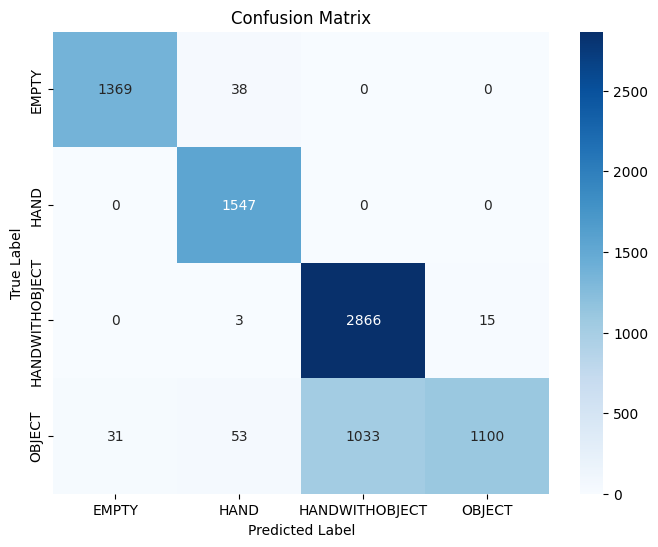

In [11]:
def compute_confusion_matrix(model, test_features, test_labels):
    y_true = []
    y_pred = []

    # Get predictions
    predictions = model.predict(test_features)
    
    # Extend true labels and predicted labels
    y_true.extend(test_labels)
    y_pred.extend(predictions)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    return conf_matrix, y_true, y_pred

def compute_accuracy_from_confusion_matrix(conf_matrix):
    # Accuracy is the sum of the diagonal elements (true positives) divided by the total number of samples
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    return accuracy

# Assuming `clf` is your trained SVM model and `test_features`, `test_labels` are your test data
conf_matrix, y_true, y_pred = compute_confusion_matrix(clf_best, test_features, test_labels)

accuracy = compute_accuracy_from_confusion_matrix(conf_matrix)
print(f"ACCURACY: {accuracy * 100:.2f}%")

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names for your classes
class_names = ["EMPTY", "HAND", "HANDWITHOBJECT", "OBJECT"]

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)
